In [82]:
# Import library yang diperlukan
# from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback
#ignore warning
import warnings
warnings.filterwarnings('ignore')

In [83]:
# Mount Google Drive
# drive.mount('/content/drive')

# Import Data

In [84]:
# Ganti 'nama_file.csv' dengan nama file CSV yang ingin Anda baca
# nama_file = '/content/drive/MyDrive/UTY/Semester 7/Data Science/Seminar Nasional/Data_Tanaman_Padi_Sumatera_version_1.csv'
nama_file = './Dataset/Data_Tanaman_Padi_Sumatera_version_1.csv'
# Membaca file CSV dan menyimpannya dalam bentuk DataFrame
df = pd.read_csv(nama_file, delimiter = ',')
df_copy = df.copy()

# Data Exploration

In [85]:
df.head()

,Provinsi,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
0,Aceh,1993,1329536.0,323589.0,1627.0,82.00,26.06
1,Aceh,1994,1299699.0,329041.0,1521.0,82.12,26.92
2,Aceh,1995,1382905.0,339253.0,1476.0,82.72,26.27
3,Aceh,1996,1419128.0,348223.0,1557.0,83.00,26.08
4,Aceh,1997,1368074.0,337561.0,1339.0,82.46,26.31


In [86]:
print(f'Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom' )

Dataset memiliki 224 baris dan 7 kolom


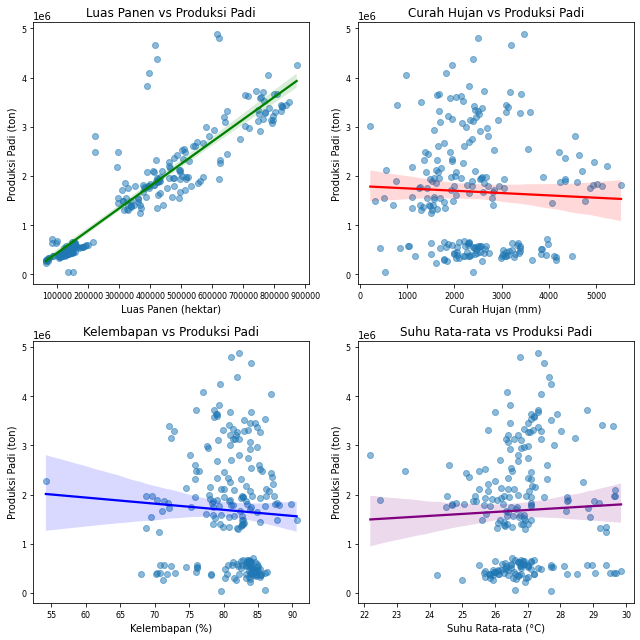

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Hubungan antara luas panen dan produksi padi
sns.regplot(ax=axes[0, 0], x=df['Luas Panen'], y=df['Produksi'], scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
axes[0, 0].set_title('Luas Panen vs Produksi Padi')
axes[0, 0].set_xlabel('Luas Panen (hektar)')
axes[0, 0].set_ylabel('Produksi Padi (ton)')
axes[0, 0].tick_params(labelsize=8)

# Hubungan antara curah hujan dan produksi padi
sns.regplot(ax=axes[0, 1], x='Curah hujan', y='Produksi', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 1].set_title('Curah Hujan vs Produksi Padi')
axes[0, 1].set_xlabel('Curah Hujan (mm)')
axes[0, 1].set_ylabel('Produksi Padi (ton)')
axes[0, 1].tick_params(labelsize=8)

# Hubungan antara kelembapan dan produksi padi
sns.regplot(ax=axes[1, 0], x=df['Kelembapan'], y=df['Produksi'], scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
axes[1, 0].set_title('Kelembapan vs Produksi Padi')
axes[1, 0].set_xlabel('Kelembapan (%)')
axes[1, 0].set_ylabel('Produksi Padi (ton)')
axes[1, 0].tick_params(labelsize=8)

# Hubungan antara suhu rata-rata dan produksi padi
sns.regplot(ax=axes[1, 1], x=df['Suhu rata-rata'], y=df['Produksi'], scatter_kws={'alpha':0.5}, line_kws={'color':'purple'})
axes[1, 1].set_title('Suhu Rata-rata vs Produksi Padi')
axes[1, 1].set_xlabel('Suhu Rata-rata (°C)')
axes[1, 1].set_ylabel('Produksi Padi (ton)')
axes[1, 1].tick_params(labelsize=8)

plt.tight_layout()
plt.show()

Gabungan visualisasi tersebut kini mencakup hubungan antara curah hujan dan produksi padi serta faktor-faktor yang telah dibahas sebelumnya:
- Luas Panen dan Produksi Padi: Korelasi positif antara luas panen dan produksi menunjukkan bahwa peningkatan luas tanam padi dapat meningkatkan produksi secara keseluruhan.
- Curah Hujan dan Produksi Beras: Penambahan plot hubungan curah hujan memperkuat korelasi positif antara curah hujan dan produksi beras, yang menunjukkan bahwa pasokan air yang cukup dari curah hujan bermanfaat bagi hasil panen padi.
- Kelembapan dan Produksi Beras: Keberagaman dalam hubungan antara kelembapan dan produksi menunjukkan bahwa kelembapan saja bukan merupakan prediktor yang kuat terhadap tingkat produksi, kemungkinan besar disebabkan oleh kemampuan adaptasi beras terhadap tingkat kelembapan yang berbeda.
- Suhu Rata-rata dan Produksi Beras: Hubungan antara suhu dan produksi nampaknya lemah, hal ini menunjukkan bahwa dalam kisaran suhu yang diamati, produksi beras tidak terlalu sensitif terhadap variasi suhu di Sumatera.

Secara keseluruhan, visualisasi ini memberikan gambaran komprehensif tentang bagaimana berbagai faktor lingkungan berkorelasi dengan produksi padi di Sumatera. Curah hujan yang cukup dan lahan pertanian yang cukup tampaknya menjadi faktor kunci dalam memaksimalkan hasil panen padi, sementara kelembapan dan suhu dalam kisaran normal di wilayah tersebut mempunyai pengaruh yang kurang jelas. Wawasan ini dapat menjadi masukan bagi kebijakan pertanian yang berfokus pada pengelolaan air, penggunaan lahan, dan strategi adaptasi iklim.

In [88]:
df.describe()

,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
count,224.000000,2.240000e+02,224.000000,224.000000,224.000000,224.000000
mean,2006.500000,1.679701e+06,374349.966920,2452.490759,80.948705,26.801964
std,8.095838,1.161387e+06,232751.161987,1031.972625,4.878680,1.197041
min,1993.000000,4.293800e+04,63142.040000,222.500000,54.200000,22.190000
25%,1999.750000,5.488570e+05,146919.500000,1703.525000,78.975000,26.177500
50%,2006.500000,1.667773e+06,373551.500000,2315.700000,82.375000,26.730000
75%,2013.250000,2.436851e+06,514570.250000,3039.700000,84.000000,27.200000
max,2020.000000,4.881089e+06,872737.000000,5522.000000,90.600000,29.850000


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provinsi        224 non-null    object 
 1   Tahun           224 non-null    int64  
 2   Produksi        224 non-null    float64
 3   Luas Panen      224 non-null    float64
 4   Curah hujan     224 non-null    float64
 5   Kelembapan      224 non-null    float64
 6   Suhu rata-rata  224 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.4+ KB


In [90]:
cek = pd.DataFrame({
    'Data Kosong': df.isnull().sum(),
    'Data Duplikat': df.duplicated().sum(),
    'Data NaNN': df.isna().sum(),
    'Type Data': df.dtypes
})

cek

,Data Kosong,Data Duplikat,Data NaNN,Type Data
Provinsi,0,0,0,object
Tahun,0,0,0,int64
Produksi,0,0,0,float64
Luas Panen,0,0,0,float64
Curah hujan,0,0,0,float64
Kelembapan,0,0,0,float64
Suhu rata-rata,0,0,0,float64


In [91]:
df.corr()

,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
Tahun,1.000000,0.182527,-0.045951,-0.047645,-0.033474,0.004923
Produksi,0.182527,1.000000,0.905622,-0.042129,-0.052316,0.041160
Luas Panen,-0.045951,0.905622,1.000000,-0.092975,-0.061121,0.115726
Curah hujan,-0.047645,-0.042129,-0.092975,1.000000,0.056466,-0.228699
Kelembapan,-0.033474,-0.052316,-0.061121,0.056466,1.000000,-0.407799
Suhu rata-rata,0.004923,0.041160,0.115726,-0.228699,-0.407799,1.000000


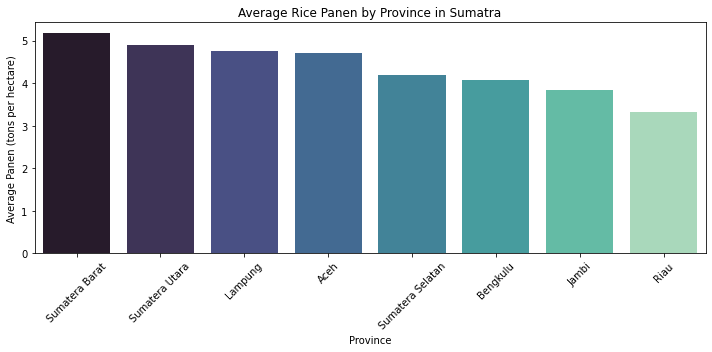

In [92]:
df['Panen'] = df['Produksi'] / df['Luas Panen']

plt.figure(figsize=(10, 5))
average_Panen_by_province = df.groupby('Provinsi')['Panen'].mean().sort_values(ascending=False)
sns.barplot(x=average_Panen_by_province.index, y=average_Panen_by_province.values, palette="mako")
plt.title('Average Rice Panen by Province in Sumatra')
plt.xlabel('Province')
plt.ylabel('Average Panen (tons per hectare)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

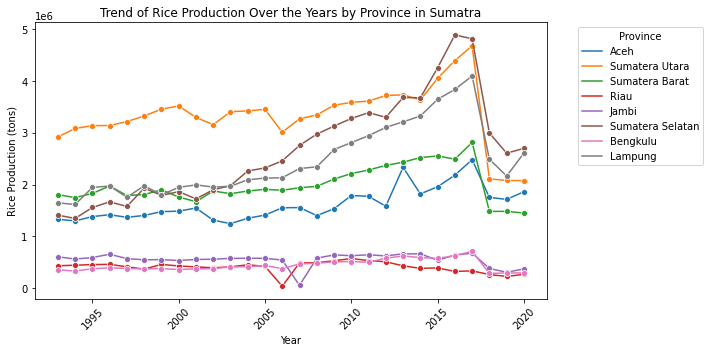

In [93]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Tahun', y='Produksi', hue='Provinsi', data=df, marker='o')
plt.title('Trend of Rice Production Over the Years by Province in Sumatra')
plt.xlabel('Year')
plt.ylabel('Rice Production (tons)')
plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Preprocessing

In [94]:
df_copy.set_index("Tahun", inplace=True)
df_copy.head()

,Provinsi,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
Tahun,,,,,,
1993,Aceh,1329536.0,323589.0,1627.0,82.00,26.06
1994,Aceh,1299699.0,329041.0,1521.0,82.12,26.92
1995,Aceh,1382905.0,339253.0,1476.0,82.72,26.27
1996,Aceh,1419128.0,348223.0,1557.0,83.00,26.08
1997,Aceh,1368074.0,337561.0,1339.0,82.46,26.31


In [95]:
df_copy['Provinsi'].unique()

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung'], dtype=object)

# Analisis Forecasting

In [96]:
# Fungsi Konversi ke timeseries
def prepare_data_for_lstm(df, province, n_past=3, n_future=1, test_size=7, drop_columns=['Provinsi']):
    # Filter and split the dataset
    province_df = df[df['Provinsi'] == province]
    if drop_columns:
        province_df = province_df.drop(columns=drop_columns)
    df_train = province_df[:-test_size]
    df_test = province_df[-test_size - n_past:]

    scaler = MinMaxScaler()
    columns = (['Produksi', 'Luas Panen', 'Curah hujan', 'Kelembapan', 'Suhu rata-rata'])
    df_train = scaler.fit_transform(df_train)
    df_test = scaler.transform(df_test)

    # Prepare training and testing sequences
    df_train = np.array(df_train)
    df_test = np.array(df_test)
    X, y = [], []
    for i in range(n_past, len(df_train) - n_future+1):
      X.append(df_train[i - n_past:i, 1:df_train.shape[1]])
      y.append(df_train[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X), np.array(y)

    X, y = [], []
    for i in range(n_past, len(df_test) - n_future+1):
      X.append(df_test[i - n_past:i, 1:df_test.shape[1]])
      y.append(df_test[i + n_future - 1:i + n_future, 0])
    X_test, y_test = np.array(X), np.array(y)

    return X_train, y_train, X_test, y_test

In [97]:
def create_lstm_model(X_train, y_train, epoch):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

    history = model.fit(X_train, y_train, epochs=epoch, validation_split=0.1, shuffle=False, verbose=0, callbacks=[TqdmCallback(verbose=1)])

    return model, history

# Implementasi

### 1.Aceh

In [98]:
df[:]

,Provinsi,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata,Panen
0,Aceh,1993,1329536.00,323589.00,1627.0,82.00,26.06,4.108718
1,Aceh,1994,1299699.00,329041.00,1521.0,82.12,26.92,3.949961
2,Aceh,1995,1382905.00,339253.00,1476.0,82.72,26.27,4.076324
3,Aceh,1996,1419128.00,348223.00,1557.0,83.00,26.08,4.075343
4,Aceh,1997,1368074.00,337561.00,1339.0,82.46,26.31,4.052820
...,...,...,...,...,...,...,...,...
219,Lampung,2016,3831923.00,390799.00,2317.6,79.40,26.45,9.805355
220,Lampung,2017,4090654.00,396559.00,1825.1,77.04,26.36,10.315373
221,Lampung,2018,2488641.91,511940.93,1385.8,76.05,25.50,4.861190
222,Lampung,2019,2164089.33,464103.42,1706.4,78.03,27.23,4.662946


In [99]:
(18, 3, 4)

(18, 3, 4)

In [100]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Aceh', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

100%|██████████| 500/500 [00:35<00:00, 14.26epoch/s, loss=0.0021, root_mean_squared_error=0.0458, val_loss=0.133, val_root_mean_squared_error=0.364] 


In [101]:
import pandas as pd
import numpy as np

# Misalkan arr adalah array (18, 3, 4)
arr = X_train_aceh[1:5]  # Gantilah ini dengan array sesuai kebutuhan

# Mengonversi array ke DataFrame
df_list = []

for i in range(arr.shape[0]):
    df_i = pd.DataFrame(arr[i], columns=[f'Feature_{j+1}' for j in range(arr.shape[2])])
    df_list.append(df_i)

df_combined = pd.concat(df_list, keys=[f'Sequence_{i+1}' for i in range(arr.shape[0])])

# Menampilkan DataFrame
print(df_combined)


              Feature_1  Feature_2  Feature_3  Feature_4
Sequence_1 0   0.272878   0.685705   0.611899   0.257485
           1   0.355252   0.655289   0.639359   0.062874
           2   0.427608   0.710037   0.652174   0.005988
Sequence_2 0   0.355252   0.655289   0.639359   0.062874
           1   0.427608   0.710037   0.652174   0.005988
           2   0.341604   0.562690   0.627460   0.074850
Sequence_3 0   0.427608   0.710037   0.652174   0.005988
           1   0.341604   0.562690   0.627460   0.074850
           2   0.570133   0.647854   0.633867   0.233533
Sequence_4 0   0.341604   0.562690   0.627460   0.074850
           1   0.570133   0.647854   0.633867   0.233533
           2   0.521130   0.859412   0.642563   0.023952


In [102]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 64)             17664     
                                                                 
 dropout_12 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 3, 32)             12416     
                                                                 
 dropout_13 (Dropout)        (None, 3, 32)             0         
                                                                 
 lstm_14 (LSTM)              (None, 16)                3136      
                                                                 
 dense_8 (Dense)             (None, 32)                544       
                                                                 
 dropout_14 (Dropout)        (None, 32)               

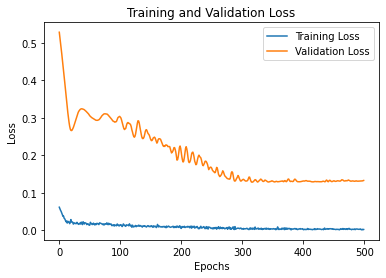

In [103]:
# Grafik Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
# Tabel Perbadingan Hasil Prediksi Dengan Hasil Aktual
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

,Train Predictions,Actual
0,0.917970,0.528800
1,1.145567,0.655021
2,1.503289,0.861409
3,1.244853,1.136363
4,0.803062,0.466035
5,-0.002962,0.431400
6,-0.017830,0.567074


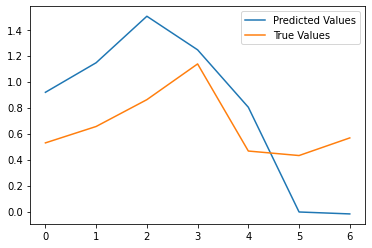

In [105]:
# Grafik Perbadingan Hasil Prediksi Dengan Hasil Aktual
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [106]:
# Menghitung Nilai RMSE
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.45673


### 2.Sumatera Utara

In [107]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Sumatera Utara', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, 500)

100%|██████████| 500/500 [00:29<00:00, 17.09epoch/s, loss=0.0258, root_mean_squared_error=0.161, val_loss=0.108, val_root_mean_squared_error=0.328] 


In [108]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 42ms/step - loss: 2.7231 - root_mean_squared_error: 1.6502


[2.7231204509735107, 1.6501879692077637]

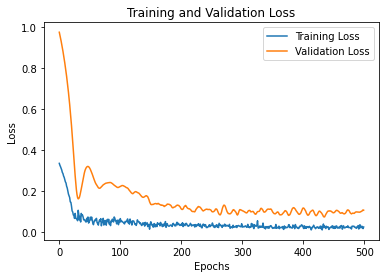

In [109]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

,Train Predictions,Actual
0,0.734916,0.881090
1,0.770123,1.392512
2,0.785431,1.815461
3,0.805635,2.164914
4,0.926945,-1.000952
5,1.419788,-1.037268
6,1.407061,-1.040508


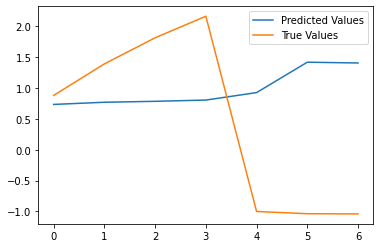

In [111]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [112]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 1.65019
